In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from dask.distributed import Client, progress
# HPC
# client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
# client

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

/srv/conda/lib/python3.6/site-packages/dask_kubernetes/config.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.3.13:37175 Dashboard: /user/0000-0001-7783-5629/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='anon', access='read_only')


In [5]:
gcsmap=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/Eta',gcs=fs,check=False,create=False)
ds=xr.open_zarr(gcsmap)

In [6]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<shape=(9030, 13, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [7]:
gcsmapgrid=gcsfs.mapping.GCSMap('pangeo-data/llc4320_surface/grid',gcs=fs,check=False,create=False)
dsgrid=xr.open_zarr(gcsmapgrid)

In [8]:
dsgrid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<shape=(2,), chunksize=(2,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<shape=(2,), chunksize=(2

In [9]:
lat=dsgrid.YC
lon=dsgrid.XC

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic


In [11]:
def plot_surf(sub,data,lon,lat,vmin,vmax,cmap,title,date):
    
    ax = plt.subplot(sub,projection=ccrs.PlateCarree(central_longitude=0))
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.pcolormesh(lon,lat,data,cmap=cmap,vmin=vmin,vmax=vmax )
    plt.colorbar(orientation='horizontal',pad=0.1, aspect=50)
    plt.title(title)
    ax.text(0.57, -0.08, date, transform=ax.transAxes)


In [12]:
data=ds.sel(time='2012-01-01T01:00:00',face=2)['Eta'].values
lonn=lon.sel(face=2).values
latt=lat.sel(face=2).values

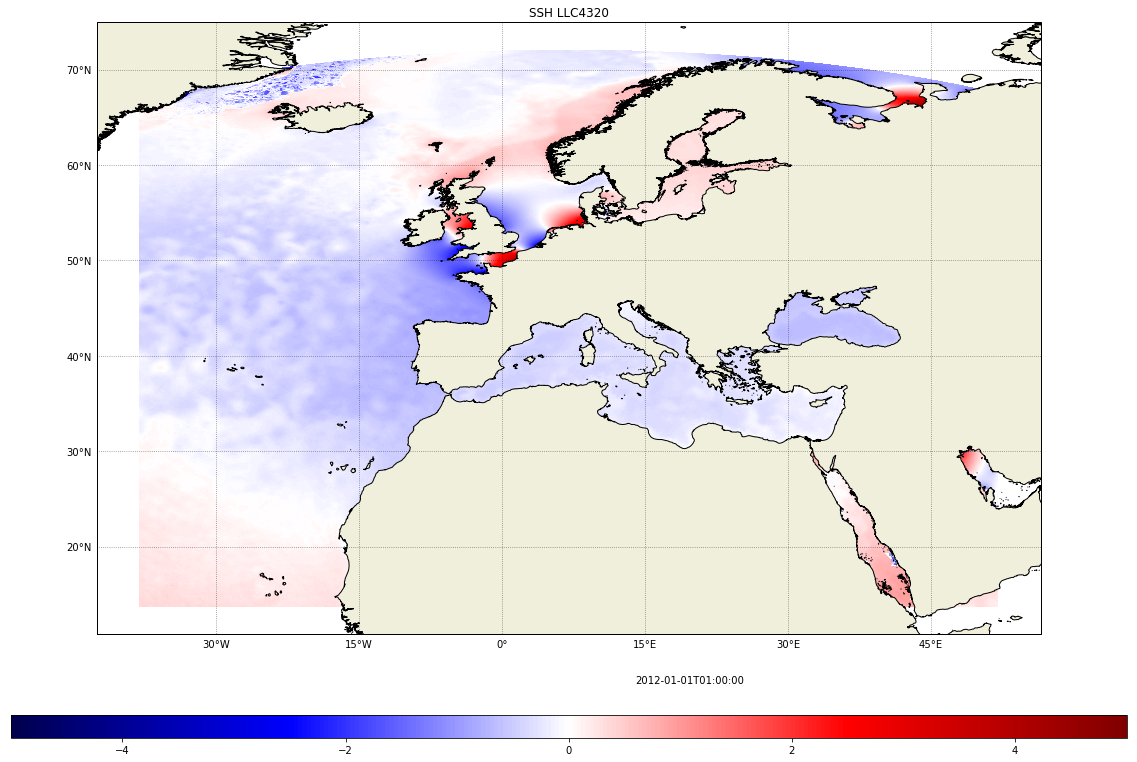

In [13]:

fig=plt.figure(figsize=(20,15))
plot_surf(111,data,lonn,latt,-5,5,div_cmap,'SSH LLC4320','2012-01-01T01:00:00')

In [14]:
data=ds.sel(time='2012-01-01T01:00:00',face=7)['Eta']
lonn=lon.sel(face=7)
latt=lat.sel(face=7)


In [15]:
print(np.min(np.where(lonn[:,-1].values<0)))

1824


In [16]:
print(np.min(np.where(lonn[:,0]<0)))

1893


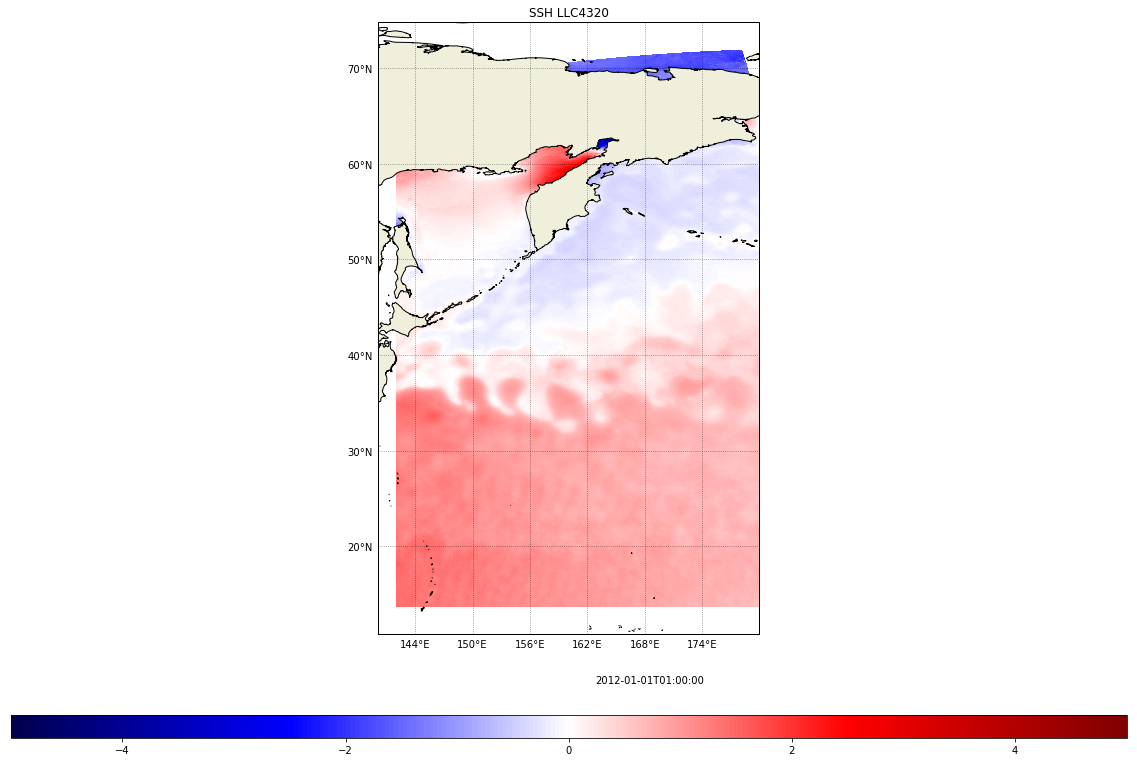

In [17]:
data=ds.sel(time='2012-01-01T01:00:00',face=7)['Eta'][0:1822,:]
lonn=lon.sel(face=7)[0:1822,:]
latt=lat.sel(face=7)[0:1822,:]


fig=plt.figure(figsize=(20,15))
plot_surf(111,data,lonn,latt,-5,5,div_cmap,'SSH LLC4320','2012-01-01T01:00:00')

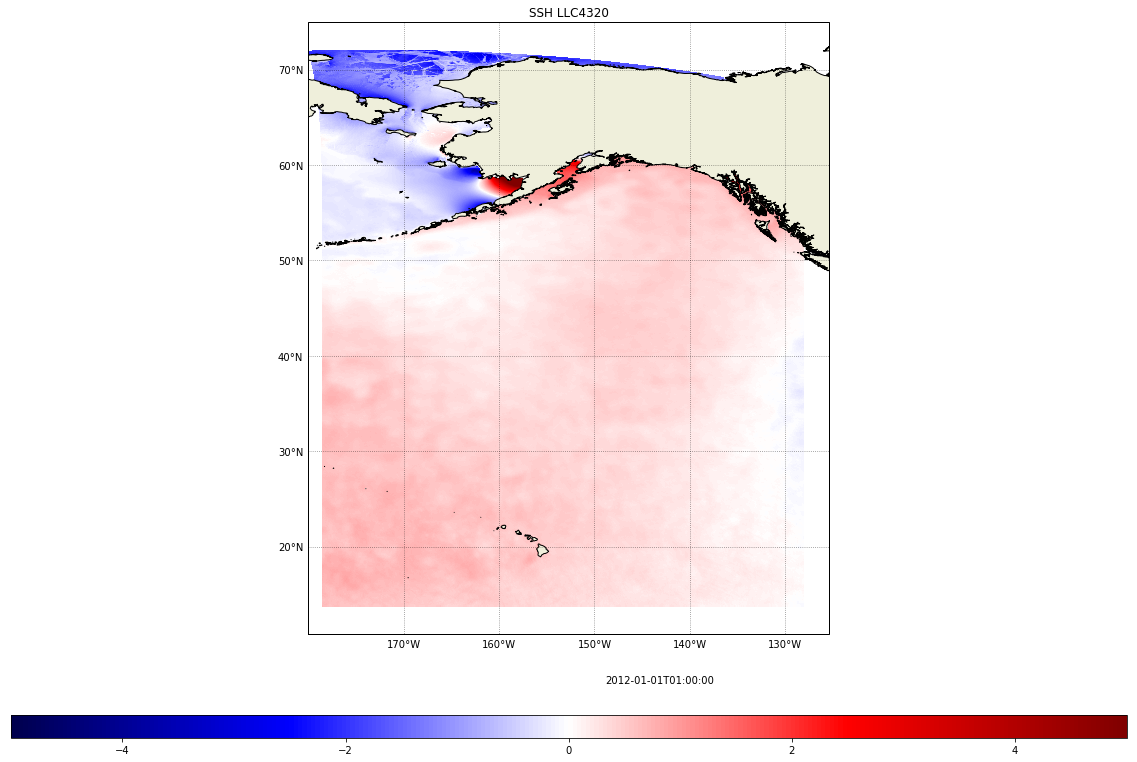

In [18]:
data=ds.sel(time='2012-01-01T01:00:00',face=7)['Eta'][1894:-1,:]
lonn=lon.sel(face=7)[1894:-1,:]
latt=lat.sel(face=7)[1894:-1,:]


fig=plt.figure(figsize=(20,15))
plot_surf(111,data,lonn,latt,-5,5,div_cmap,'SSH LLC4320','2012-01-01T01:00:00')

In [19]:
data=ds.sel(time='2012-01-01T01:00:00',face=8)['Eta']
lonn=lon.sel(face=8)
latt=lat.sel(face=8)
print(np.min(np.where(lonn[:,-1].values<0)))
print(np.min(np.where(lonn[:,0]<0)))

1824
1824


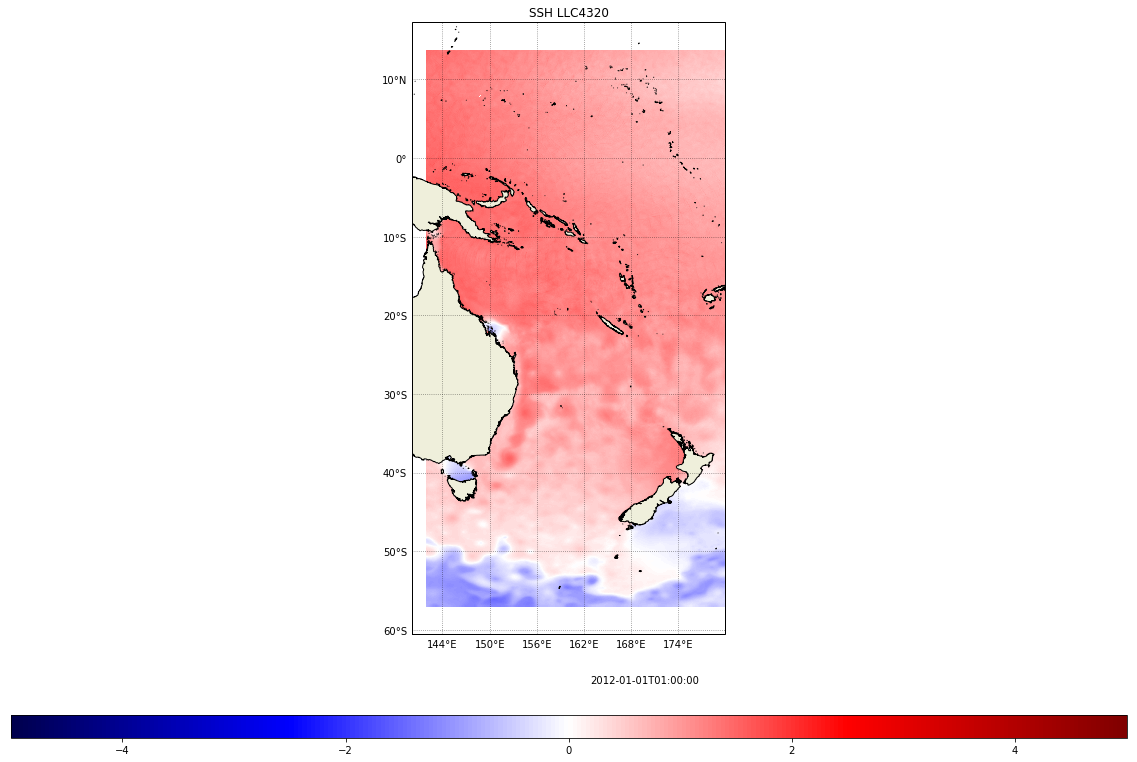

In [21]:
data=ds.sel(time='2012-01-01T01:00:00',face=8)['Eta'][0:1822,:]
lonn=lon.sel(face=8)[0:1822,:]
latt=lat.sel(face=8)[0:1822,:]


fig=plt.figure(figsize=(20,15))
plot_surf(111,data,lonn,latt,-5,5,div_cmap,'SSH LLC4320','2012-01-01T01:00:00')